In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import pandas as pd
import cv2
import os
import xml.etree.ElementTree as xet
## Importing object detection models
from tensorflow.keras.applications import MobileNetV2, InceptionV3, InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
import numpy as np
import mlflow

df = pd.read_csv('Image-Labels.csv')
labels = df.iloc[:,1:].values

def getFilename(filename):
    filename_image = xet.parse(filename).getroot().find('filename').text
    filepath_image = os.path.join(r'C:\Users\adi3m\Downloads\Project_Files\1_Labeling\images',filename_image)
    return filepath_image


image_path = list(df['filepath'].apply(getFilename))

data = []
output = []
## Iterate  all the images
for ind in range(len(image_path)):
    image = image_path[ind]
    # Reads the image using open cv
    img_arr = cv2.imread(image)
    # Get the height width and number of channels
    h,w,d = img_arr.shape
    # prepprocesing
    # load image using keras function
    load_image = load_img(image,target_size=(224,224))
    # Convert the image to numpy array
    load_image_arr = img_to_array(load_image)
    ## Array is normalized by dividing each scale by 255 to scale them between 0 and 1
    norm_load_image_arr = load_image_arr/255.0 # normalization
    # normalization to labels
    xmin,xmax,ymin,ymax = labels[ind]
    nxmin,nxmax = xmin/w,xmax/w
    nymin,nymax = ymin/h,ymax/h
    label_norm = (nxmin,nxmax,nymin,nymax) # normalized output
    # -------------- append
    data.append(norm_load_image_arr)
    output.append(label_norm)
    
    
X = np.array(data,dtype=np.float32)
y = np.array(output,dtype=np.float32)

# Assuming X and y are defined and loaded with your data

x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

# Creating an InceptionResNetV2 model using pre-trained weights from ImageNet.
inception_resnet = InceptionResNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
inception_resnet.trainable = False

# Head model
headmodel = inception_resnet.output
headmodel = Flatten()(headmodel)
headmodel = Dense(500, activation="relu")(headmodel)
headmodel = Dense(250, activation="relu")(headmodel)
headmodel = Dense(4, activation='sigmoid')(headmodel)

# Final model
#the Model class is used to instantiate a Keras model. It allows us to specify the inputs and outputs of the model, defining the computation graph that connects the inputs to the outputs.
model = Model(inputs=inception_resnet.input, outputs=headmodel)

# Compile model
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

mlflow.set_tracking_uri("http://localhost:8080")


In [ ]:

# Log model architecture
with mlflow.start_run() as run:
    # Log custom hyperparameters or parameters
    mlflow.log_param("dense_units_1", 500)
    mlflow.log_param("dense_units_2", 250)
    mlflow.log_param("output_activation", "sigmoid")

    # Model training
    ## x_train: This is the training data, typically a NumPy array or a TensorFlow Dataset, containing the input features for the training set.

    ## y_train: This is the target or label corresponding to each input in x_train. It represents the ground truth for the training set.

    ## batch_size: The number of samples that will be used in each iteration (gradient update) during training. In this case, the model will be updated after processing every 10 samples.

    ## epochs: An epoch is one complete pass through the entire training dataset. The model will be trained for 10 epochs, meaning it will see the entire training dataset 10 times.

    ## validation_data: This parameter is used to provide a separate dataset (validation set) on which to evaluate the model's performance during training. It helps to monitor for overfitting and assess generalization.

    ## callbacks: Callbacks are functions that can be applied at different stages of the training process. In this case, tfb (TensorBoard) is a callback used to log metrics and visualize the training process in TensorBoard.

    ## TensorBoard (tfb): It's a visualization tool that comes with TensorFlow. By providing this callback, the training process will log metrics such as loss and any other metrics specified in the model compilation to a directory. TensorBoard can then be used to visualize these metrics over time, compare training and validation performance, and inspect the model graph.
    tfb = TensorBoard('object_detection')
    history = model.fit(x=x_train, y=y_train, batch_size=10, epochs=50,
                        validation_data=(x_test, y_test), callbacks=[tfb])

    # Log metrics
    mlflow.log_param("batch_size", 10)
    mlflow.log_param("epochs", 10)
    mlflow.log_param("learning_rate", 1e-4)
    mlflow.log_metric("train_loss", history.history['loss'][-1])
    mlflow.log_metric("val_loss", history.history['val_loss'][-1])

    # Save model
    # model.save('./models/object_detection.h5')
    mlflow.tensorflow.log_model(model, "best_model")
    

In [4]:
%reload_ext tensorboard

%tensorboard --logdir="object-detection" .

ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--logdir_spec PATH_SPEC]
                   [--host ADDR] [--bind_all] [--port PORT]
                   [--reuse_port BOOL] [--load_fast {false,auto,true}]
                   [--extra_data_server_flags EXTRA_DATA_SERVER_FLAGS]
                   [--grpc_creds_type {local,ssl,ssl_dev}]
                   [--grpc_data_provider PORT] [--purge_orphaned_data BOOL]
                   [--db URI] [--db_import] [--inspect] [--version_tb]
                   [--tag TAG] [--event_file PATH] [--path_prefix PATH]
                   [--window_title TEXT] [--max_reload_threads COUNT]
                   [--reload_interval SECONDS] [--reload_task TYPE]
                   [--reload_multifile BOOL]
                   [--reload_multifile_inactive_secs SECONDS]
                   [--generic_data TYPE]
                   [--samples_per_plugin SAMPLES_PER_PLUGIN]
                   [-

In [5]:
import mlflow
import numpy as np

from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import cv2
mlflow.set_tracking_uri("http://localhost:8080")
logged_model = 'runs:/4338809bfeec443c9b6c248c2300c27c/best_model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

C:\Users\adi3m\anaconda3\Lib\site-packages\pydantic\_internal\_fields.py:149: UserWarning: Field "model_server_url" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
C:\Users\adi3m\anaconda3\Lib\site-packages\pydantic\_internal\_config.py:318: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)


2023/11/14 03:36:41 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false
C:\Users\adi3m\anaconda3\Lib\site-packages\keras\src\backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


1/1 [==============================] - 0s 187ms/step
(416, 340) (723, 412)


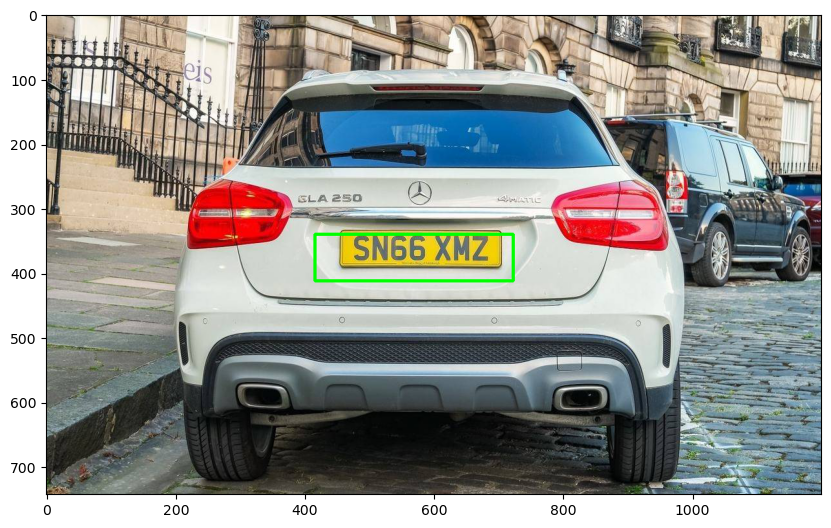

In [18]:

def object_detection(path):
    # read image
    image = load_img(path) # PIL object
    image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
    image1 = load_img(path,target_size=(224,224))
    # data preprocessing
    image_arr_224 = img_to_array(image1)/255.0  # convert into array and get the normalized output
    h,w,d = image.shape
    test_arr = image_arr_224.reshape(1,224,224,3)
    # make predictions
    coords = loaded_model.predict(test_arr)
    # denormalize the values
    denorm = np.array([w,w,h,h])
    coords = coords * denorm
    coords = coords.astype(np.int32)
    # draw bounding on top the image
    xmin, xmax,ymin,ymax = coords[0]
    pt1 =(xmin,ymin)
    pt2 =(xmax,ymax)
    print(pt1, pt2)
    cv2.rectangle(image,pt1,pt2,(0,255,0),3)
    return image, coords

# path = r"C:\Users\adi3m\Downloads\Project_Files\1_Labeling\images\N38.jpeg"
path ='why-are-number-plates-yellow-and-white.jpg'
image, cods = object_detection(path)

plt.figure(figsize=(10,8))
plt.imshow(image)
plt.show()

In [11]:
import pytesseract
import numpy as np
pytesseract.pytesseract.tesseract_cmd = r'C:\Users\adi3m\Downloads\tesseract-ocr-w64-setup-5.3.3.20231005.exe'

In [19]:
img = np.array(load_img(path))
xmin ,xmax,ymin,ymax = cods[0]
roi = img[ymin:ymax,xmin:xmax]



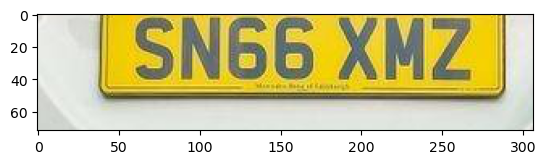

In [20]:
plt.imshow(roi)

In [14]:
# Extract the text from the image
text = pytesseract.image_to_string(roi)

OSError: [WinError 740] The requested operation requires elevation